In [1]:
import sys
sys.path.append("../src")

In [2]:
from pynwb import NWBHDF5IO
import numpy as np

from population_analysis.population.plots.pca_meta import run_pca
from population_analysis.quantification import QuanDistribution
from population_analysis.quantification.euclidian import EuclidianQuantification
from matplotlib.patches import Ellipse
from matplotlib import animation
%matplotlib widget
import matplotlib.pyplot as plt

In [3]:
filepath = "../scripts/2023-05-15_mlati7_output.nwb"

nwbio = NWBHDF5IO(filepath)
nwb = nwbio.read()

probe_trial_idxs = nwb.processing["behavior"]["unit-trial-probe"].data[:]
saccade_trial_idxs = nwb.processing["behavior"]["unit-trial-saccade"].data[:]

# (units, trials, t)
probe_units = nwb.units["trial_response_firing_rates"].data[:, probe_trial_idxs]
saccade_units = nwb.units["trial_response_firing_rates"].data[:, saccade_trial_idxs]

# pca_units should be a
num_units = probe_units.shape[0]
pca_probe_units = probe_units.swapaxes(0, 2).reshape((-1, num_units))
pca_saccade_units = saccade_units.swapaxes(0, 2).reshape((-1, num_units))
pca_units = np.vstack([pca_probe_units, pca_saccade_units])
pca, data = run_pca(pca_units, components=2)
tw = 2

In [4]:
def plot_pcad_datas(axx, probe_pcad, saccade_pcad):
    probe_mean = np.mean(probe_pcad, axis=0)
    saccade_mean = np.mean(saccade_pcad, axis=0)
    
    probe_std = np.std(probe_pcad, axis=0)
    saccade_std = np.std(saccade_pcad, axis=0)

    plots = []
    
    plots.append(axx.scatter(probe_pcad[:,0], probe_pcad[:,1], color='bisque', alpha=0.8))
    plots.append(axx.scatter(saccade_pcad[:,0], saccade_pcad[:,1], color='cornflowerblue', alpha=0.8))
    
    plots.append(axx.scatter(*probe_mean, color='orange'))
    plots.append(axx.scatter(*saccade_mean, color='blue'))
    
    
    probe_ellipse = Ellipse(xy=probe_mean, width=probe_std[0], height=probe_std[1], 
                            edgecolor='orange', fc='None', lw=2)
    saccade_ellipse = Ellipse(xy=saccade_mean, width=saccade_std[0], height=saccade_std[1], 
                            edgecolor='blue', fc='None', lw=2)
    plots.append(axx.add_patch(probe_ellipse))
    plots.append(axx.add_patch(saccade_ellipse))
    return plots


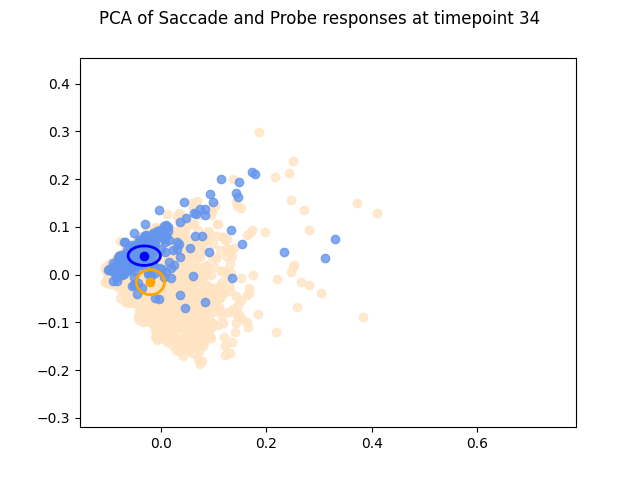

In [5]:
pca_plot_data = {"data": []}
fig = plt.figure()
ax = fig.add_subplot() # projection='3d')

def pca_ani(frame):
    [v.remove() for v in pca_plot_data["data"]]
    pca_timepoint = frame % 35
    probe_pcad2 = pca.transform(probe_units[:,:,pca_timepoint].swapaxes(0, 1))
    saccade_pcad2 = pca.transform(saccade_units[:,:,pca_timepoint].swapaxes(0,1))  # (trials, 2)
    plotted_pcas = plot_pcad_datas(ax, probe_pcad2, saccade_pcad2)
    fig.suptitle(f"PCA of Saccade and Probe responses at timepoint {pca_timepoint}")
    pca_plot_data["data"] = plotted_pcas
    return pca_plot_data

ani = animation.FuncAnimation(fig=fig, func=pca_ani, frames=35)
ani.save(filename="timepoint_responses.gif", writer="pillow")

In [4]:
def interpolate(pt1, pt2) -> list[list[float]]:
    x1, y1 = pt1[0], pt1[1]
    x2, y2 = pt2[0], pt2[1]
    dx = x2 - x1
    dy = y2 - y1
    num_samples = 25
    dx = dx / num_samples
    dy = dy / num_samples
    points = []
    for samp in range(num_samples):
        points.append([x1+dx*samp, y1+dy*samp])
    return np.array(points)


In [5]:
num_timepoints = 35

saccade_avgs = np.array([np.mean(pca.transform(saccade_units[:,:,tp].swapaxes(0,1)), axis=0) for tp in range(num_timepoints)])
probe_avgs = np.array([np.mean(pca.transform(probe_units[:,:,tp].swapaxes(0,1)), axis=0) for tp in range(num_timepoints)])

In [6]:
saccade_avgs.shape, probe_avgs.shape

((35, 2), (35, 2))

In [28]:
saccade_avgs[1][1]

0.016096912270539537

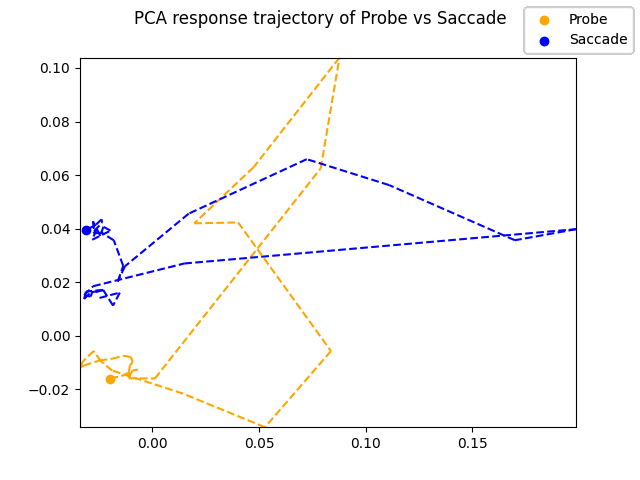

In [44]:
pca_line_data = {"data": []}
fig.clf()
plt.close()
fig = plt.figure()
ax = fig.add_subplot()

def pca_line_ani(frame):
    [v.remove() for v in pca_line_data["data"]]
    pca_timepoint = frame % 35

    to_plot = []
    
    sac_tail_points = []
    probe_tail_points = []
    for pt in range(pca_timepoint + 1):
        if pt > 34 or pt == 0:
            continue
        to_plot.extend(ax.plot(
            [saccade_avgs[pt-1][0], saccade_avgs[pt][0]],
            [saccade_avgs[pt-1][1], saccade_avgs[pt][1]], 
            color="blue", 
            linestyle="dashed"
        ))
        to_plot.extend(ax.plot(
            [probe_avgs[pt-1][0], probe_avgs[pt][0]],
            [probe_avgs[pt-1][1], probe_avgs[pt][1]], 
            color="orange", 
            linestyle="dashed"
        ))
    xmax = max(probe_avgs[:,0].max(), saccade_avgs[:,0].max())
    xmin = min(probe_avgs[:,0].min(), saccade_avgs[:,0].min())
    ymax = max(probe_avgs[:,1].max(), saccade_avgs[:,1].max())
    ymin = min(probe_avgs[:,1].min(), saccade_avgs[:,1].min())
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    to_plot.append(ax.scatter(*probe_avgs[pca_timepoint], color="orange", label="Probe"))
    to_plot.append(ax.scatter(*saccade_avgs[pca_timepoint], color="blue", label="Saccade"))  
    fig.legend()
    # plotted_pcas = plot_pcad_datas(ax, probe_pcad2, saccade_pcad2)
    
    #plt.title(f"PCA of Saccade and Probe responses at timepoint {pca_timepoint}")
    pca_line_data["data"] = to_plot
    return to_plot
fig.suptitle("Mean PCA response trajectory of Probe vs Saccade")

ani = animation.FuncAnimation(fig=fig, func=pca_line_ani, frames=35)

ani.save(filename="timepoint_means.gif", writer="pillow")

Plotting mean trajectories in 3d


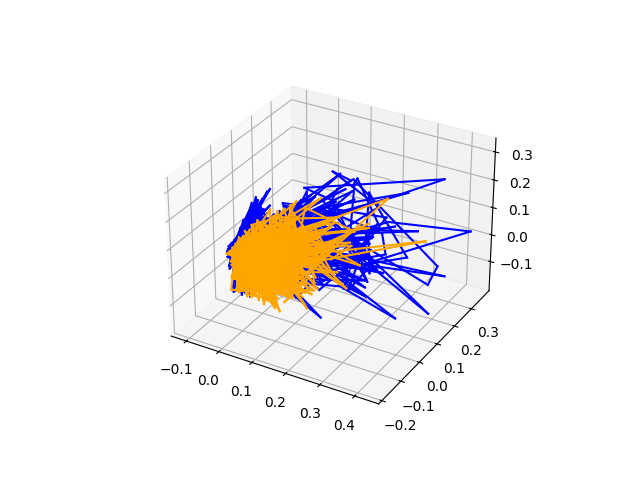

In [5]:
print("Plotting mean trajectories in 3d")

pca, data = run_pca(pca_units, components=3)
num_timepoints = 35

saccade_vals = np.array([pca.transform(saccade_units[:, :, tp].swapaxes(0, 1)) for tp in range(num_timepoints)])
probe_vals = np.array([pca.transform(probe_units[:, :, tp].swapaxes(0, 1)) for tp in range(num_timepoints)])

ax = plt.figure().add_subplot(projection='3d')
colors = plt.get_cmap("hsv")
for j in range(len(saccade_vals)):
    for i in range(1, num_timepoints):
        ax.plot(*saccade_vals[j][i - 1:i + 1].T, c="blue")

for j in range(len(probe_vals)):
    for i in range(1, num_timepoints):
        ax.plot(*probe_vals[j][i - 1:i + 1].T, c="orange")

plt.show()